# Desafio final do Bootcamp de Cientista de Dados do IGTI

## Objetivos de Ensino

Exercitar os seguintes conceitos trabalhados no Módulo:    

    ✔ Pré-processamento dos dados
    ✔ Detecção de anomalias
    ✔ Processamento dos dados
    ✔ Correlações
    ✔ Spark MlLib
    ✔ Interpretação dos dados

## Enunciado

O derrame é uma das doenças que mais acometem a população mundial. Segundo a World Health Organization (WHO), o Acidente Vascular Cerebral (AVC) foi a segunda maior causa de morte na população mundial no ano de 2016 (https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death).

Neste desafio, vamos realizar uma análise sobre um banco de dados composto por uma pesquisa realizada com diferentes pacientes. Nesta
análise, vamos tentar prever, nos baseando em algumas características específicas, se um determinado indivíduo irá ou não sofrer um AVC. Para isso, vamos aplicar o pré-processamento dos dados e a aplicar o modelo de Regressão Logística e o SVM, para indicar se um indivíduo possui ou não maior probabilidade de desenvolver o AVC.

## 1) Iniciar a seção SPARK

In [1]:
from pyspark.sql import SparkSession #importa a biblioteca que cria a seção do spark

In [2]:
#inicia a seção para a utilização do spark
spark = SparkSession.builder.appName("Desafio_IGTI").getOrCreate() #cria a seção caso não exista ou obtém a já criada

In [3]:
diretorio_dataset="healthcare-dataset-stroke-data.csv"  #diretório que contém o arquivo a ser utilizado

In [4]:
dataset_desafio = spark.read.format("csv").options(header="true", inferschema="true").load(diretorio_dataset)  #realiza a leitura do dataset

In [5]:
dataset_desafio.printSchema() #mostra o esquema inferido pelas variáveis

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



### Respectivamente, quantas variáveis do tipo string e inteira existem no dataset?

In [6]:
#número de instancias no dataset
dataset_desafio.count()

5110

### Quantas instâncias e atributos, respectivamente, existem no dataset?

In [7]:
dataset_desafio.show() #mostra as linhas iniciais do dataset

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

### 2) Conhecendo o dataset

In [8]:
#seleção de colunas
dataset_desafio.select('age','hypertension').show(5)

+----+------------+
| age|hypertension|
+----+------------+
|67.0|           0|
|61.0|           0|
|80.0|           0|
|49.0|           0|
|79.0|           1|
+----+------------+
only showing top 5 rows



In [15]:
#agrupando os dados
dataset_desafio.groupby(['gender','stroke']).count().sort("count",ascending=True).show()

+------+------+-----+
|gender|stroke|count|
+------+------+-----+
| Other|     0|    1|
|  Male|     1|  108|
|Female|     1|  141|
|  Male|     0| 2007|
|Female|     0| 2853|
+------+------+-----+



### Analisando a tabela anterior, o que podemos dizer sobre o derrame entre homens e mulheres?

In [17]:
#agrupando os dados
dataset_desafio.groupby('smoking_status','stroke').count().sort("count",ascending=True).show()

+---------------+------+-----+
| smoking_status|stroke|count|
+---------------+------+-----+
|         smokes|     1|   42|
|        Unknown|     1|   47|
|formerly smoked|     1|   70|
|   never smoked|     1|   90|
|         smokes|     0|  747|
|formerly smoked|     0|  815|
|        Unknown|     0| 1497|
|   never smoked|     0| 1802|
+---------------+------+-----+



In [18]:
#agrupando os dados
dataset_desafio.groupby('hypertension','stroke').count().sort("count",ascending=True).show()

+------------+------+-----+
|hypertension|stroke|count|
+------------+------+-----+
|           1|     1|   66|
|           0|     1|  183|
|           1|     0|  432|
|           0|     0| 4429|
+------------+------+-----+



### O que podemos dizer sobre o gráfico anterior?

In [19]:
dataset_desafio.groupby('stroke').count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



### O dataset está balanceado?

In [20]:
#utilizando crosstab para contar a quantidade de indivíduos com que ganho mais de 50K pela idade
dataset_desafio.filter(dataset_desafio.gender== 'Female').count()

2994

In [22]:
from pyspark.sql.functions import asc

#contando as classes
dataset_desafio.groupBy("work_type").agg({'work_type': 'count'}).sort(asc("count(work_type)")).show()

+-------------+----------------+
|    work_type|count(work_type)|
+-------------+----------------+
| Never_worked|              22|
|     Govt_job|             657|
|     children|             687|
|Self-employed|             819|
|      Private|            2925|
+-------------+----------------+



In [24]:
entradas_numericas= ['age',"avg_glucose_level", "bmi"]
dataset_desafio.describe(entradas_numericas).show(truncate=False)

+-------+------------------+------------------+------------------+
|summary|age               |avg_glucose_level |bmi               |
+-------+------------------+------------------+------------------+
|count  |5110              |5110              |5110              |
|mean   |43.226614481409015|106.14767710371804|28.893236911794673|
|stddev |22.61264672311348 |45.28356015058193 |7.85406672968016  |
|min    |0.08              |55.12             |10.3              |
|max    |82.0              |271.74            |N/A               |
+-------+------------------+------------------+------------------+



### Qual é a média das idades dos participantes da pesquisa?

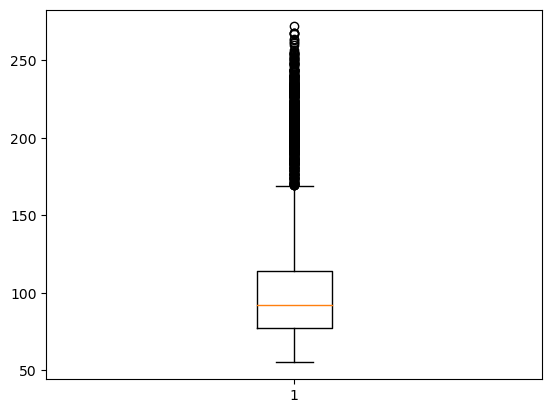

In [31]:
import matplotlib.pyplot as plt

# Converte a coluna avg_glucose_level em um objeto pandas
converter_avg_glucose_level = dataset_desafio.select('avg_glucose_level').toPandas()['avg_glucose_level']

#boxplot
plt.boxplot(converter_avg_glucose_level)
plt.show()

#### Pelo gráfico anterior, qual é o valor da mediana?

#### Pelo gráfico anterior, o que podemos dizer sobre a existência ou não de outliers?

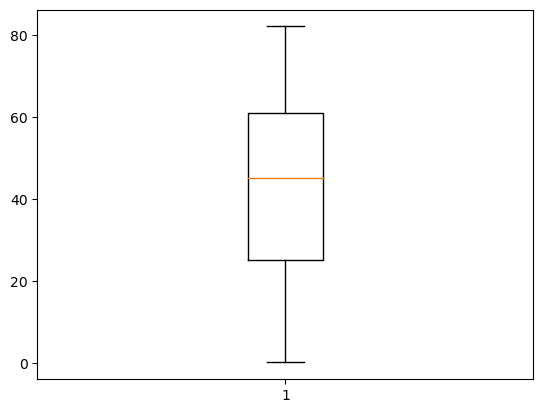

In [32]:
# Converte a coluna avg_glucose_level em um objeto pandas
converter_age = dataset_desafio.select('age').toPandas()['age']

#boxplot
plt.boxplot(converter_age)
plt.show()

#### Pelo gráfico anterior, qual é o valor do primeiro quartil?

#### Pelo gráfico anterior, o que podemos dizer sobre os outliers?

## 3) Pré-processamento dos dados

In [33]:
#contando a quantidade de valores desconhecidos
from pyspark.sql.functions import *
dataset_desafio.groupby('Residence_type').agg({'Residence_type': 'count'}).sort(asc("count(Residence_type)")).show()

+--------------+---------------------+
|Residence_type|count(Residence_type)|
+--------------+---------------------+
|         Rural|                 2514|
|         Urban|                 2596|
+--------------+---------------------+



#### Quantas classes diferentes de trabalho (work_type) existem no dataset? Fiquem atentos, pois não é essa informação que o tabela anterior está exibindo.

In [34]:
from pyspark.sql.functions import mean
mean = dataset_desafio.select(mean(dataset_desafio['bmi'])).collect()
mean_bmi = mean[0][0]
dataset_desafio = dataset_desafio.na.fill(mean_bmi,['bmi'])

In [35]:
#aplicando o filtro para as colunas que possuem valores não conhecidos
dataset_filtrado=dataset_desafio.filter((dataset_desafio['bmi'] != 'N/A') & (dataset_desafio['smoking_status'] > 'Unknown'))

In [36]:
# aplicando a transformação dos dados categóricos
from pyspark.ml.feature import VectorAssembler,OneHotEncoder, StringIndexer

In [37]:
#define a transformação para a variável "gender"
stringIndexer_gender=StringIndexer(inputCol="gender", outputCol="gender_encoded")  #label encoding
encoder_gender = OneHotEncoder(dropLast=False, inputCol="gender_encoded", outputCol="genderVec") #one-hot encoding

In [38]:
#define a transformação para a variável "ever_married"
stringIndexer_married=StringIndexer(inputCol="ever_married", outputCol="ever_married_encoded") #label encoding
encoder_married = OneHotEncoder(dropLast=False, inputCol="ever_married_encoded", outputCol="marriedVec") #one-hot encoding

In [39]:
#define a transformação para a variável "work_type"
stringIndexer_work=StringIndexer(inputCol="work_type", outputCol="work_type_encoded")  #label encoding
encoder_work = OneHotEncoder(dropLast=False, inputCol="work_type_encoded", outputCol="workVec") #one-hot encoding

In [40]:
#define a transformação para a variável "Residence_type"
stringIndexer_residence=StringIndexer(inputCol="Residence_type", outputCol="Residence_type_encoded")  #label encoding
encoder_residence = OneHotEncoder(dropLast=False, inputCol="Residence_type_encoded", outputCol="residenceVec") #one-hot encoding

In [41]:
#define a transformação para a variável "smoking_status"
stringIndexer_smoking=StringIndexer(inputCol="smoking_status", outputCol="smoking_status_encoded")  #define o objeto
encoder_smoking = OneHotEncoder(dropLast=False, inputCol="smoking_status_encoded", outputCol="smokingVec")#one-hot encoding

In [42]:
#define a construção do vetor de entrada
colunas_entrada=['age','hypertension', 'heart_disease','avg_glucose_level','genderVec','marriedVec','workVec','residenceVec','smokingVec']
vetor_entrada = VectorAssembler(inputCols=colunas_entrada,outputCol='features')

In [43]:
#define a sequencia de transformações para o pipeline
sequencia_transformacoes=[stringIndexer_gender,stringIndexer_married,stringIndexer_work,stringIndexer_residence,stringIndexer_smoking,encoder_gender,encoder_married,encoder_work,encoder_residence,encoder_smoking,vetor_entrada]

In [44]:
from pyspark.ml import Pipeline
# Aplicando o pipeline
pipeline = Pipeline(stages=sequencia_transformacoes)
pipelineModel = pipeline.fit(dataset_filtrado)
model = pipelineModel.transform(dataset_filtrado)

In [45]:
#mostrando parte dos dados para entrada
model.select('age','gender','genderVec','ever_married','marriedVec','features').show()

+----+------+-------------+------------+-------------+--------------------+
| age|gender|    genderVec|ever_married|   marriedVec|            features|
+----+------+-------------+------------+-------------+--------------------+
|67.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,2,3,5,7,9,...|
|80.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,2,3,5,7,9,...|
|49.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,3,4,7,9,14...|
|79.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,1,3,4,7,10...|
|81.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,3,5,7,9,14...|
|74.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,1,2,3,5,7,...|
|69.0|Female|(3,[0],[1.0])|          No|(2,[1],[1.0])|(19,[0,3,4,8,9,14...|
|81.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,1,3,4,7,9,...|
|61.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,2,3,4,7,11...|
|54.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,3,4,7,9,14...|
|79.0|Female

In [46]:
#dividindo o dataset entre teste e treinamento
train_data, test_data = model.randomSplit([.8,.2],seed=1)

#### Qual foi, respectivamente, o percentual de dados escolhidos para treinamento e teste dos modelos?

In [47]:
#mostrando os dados de treinamento
train_data.columns

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke',
 'gender_encoded',
 'ever_married_encoded',
 'work_type_encoded',
 'Residence_type_encoded',
 'smoking_status_encoded',
 'genderVec',
 'marriedVec',
 'workVec',
 'residenceVec',
 'smokingVec',
 'features']

### Realizando a previsão através da Regressão Logística

In [48]:
#define o modelo de regrssão logística
from pyspark.ml.classification import LogisticRegression

#instancia o objeto para a regressão logística
lr = LogisticRegression(labelCol="stroke",featuresCol="features", maxIter=100, regParam=0.3, )

# treina o modelo
linearModel = lr.fit(train_data)

In [49]:
#realiza a previsão utilizando o modelo de regressão logística
previsao_regressao = linearModel.transform(test_data)

In [51]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#avaliando a classificação realizada pela regressão logística
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
acuracia_regressao = acc_evaluator.evaluate(previsao_regressao)
print('Regressão Logística: {0:2.2f}%'.format(acuracia_regressao*100))

Regressão Logística: 94.31%
